In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:

from inspect import getouterframes
import pandas as pd
fu= '/gdrive/MyDrive/final/fifa_user.csv'
gofu='/gdrive/MyDrive/final/game_user.csv'
eu= '/gdrive/MyDrive/final/election_user.csv'

em= '/gdrive/MyDrive/final/election_paraphrase_df.csv'
fm= '/gdrive/MyDrive/final/fifa_paraphrase_df.csv'
gofm= '/gdrive/MyDrive/final/game_paraphrase_df.csv'

fifau=pd.read_csv(fu)
gofu=pd.read_csv(gofu)
elu=pd.read_csv(eu)

fifam = pd.read_csv(fm, encoding='latin1')
gofm = pd.read_csv(gofm, encoding='latin1')
elm = pd.read_csv(em, encoding='latin1')


<ipython-input-2-8da7865f7ba3>:17: DtypeWarning: Columns (16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  elm = pd.read_csv(em, encoding='latin1')


In [3]:
pip install textstat


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.5 MB/s eta 0:00:00


In [4]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

Bert Base Personality checker

In [5]:
fifau=fifau[:10000]
fifam=fifam[:10000]

In [6]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Initialize the tokenizer and model
tokenizer = BertTokenizer.from_pretrained("Minej/bert-base-personality")
model = BertForSequenceClassification.from_pretrained("Minej/bert-base-personality")

# Check if GPU is available and move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def personality_detection(text):
    # Encode the text inputs
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt")

    # Move inputs to the same device as the model
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Perform the prediction
    with torch.no_grad():
        outputs = model(**inputs)

    # Move logits back to CPU for further processing
    predictions = outputs.logits.squeeze().detach().cpu().numpy()

    # Map predictions to labels
    label_names = ['Extroversion', 'Neuroticism', 'Agreeableness', 'Conscientiousness', 'Openness']
    result = {label_names[i]: predictions[i] for i in range(len(label_names))}

    return result


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/400 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/908 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [7]:
fifau['personality'] = fifau['clean_tweet'].apply(personality_detection)
fifam['personality'] = fifam['clean_tweet'].apply(personality_detection)


In [8]:
import pandas as pd

# Convert dictionary columns into separate columns for each trait
fifau_traits = fifau['personality'].apply(pd.Series)
fifam_traits = fifam['personality'].apply(pd.Series)

# Join these new columns back to the original dataframes
fifau = fifau.join(fifau_traits)
fifam = fifam.join(fifam_traits)


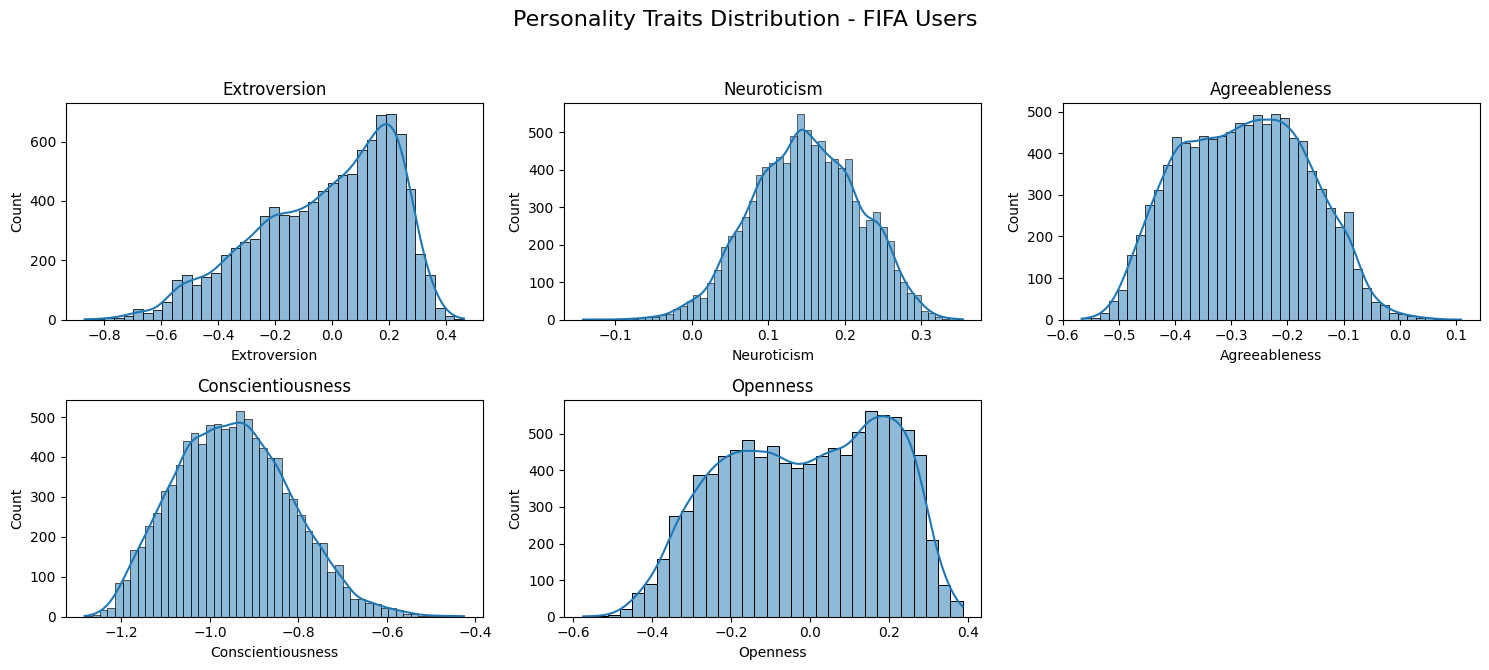

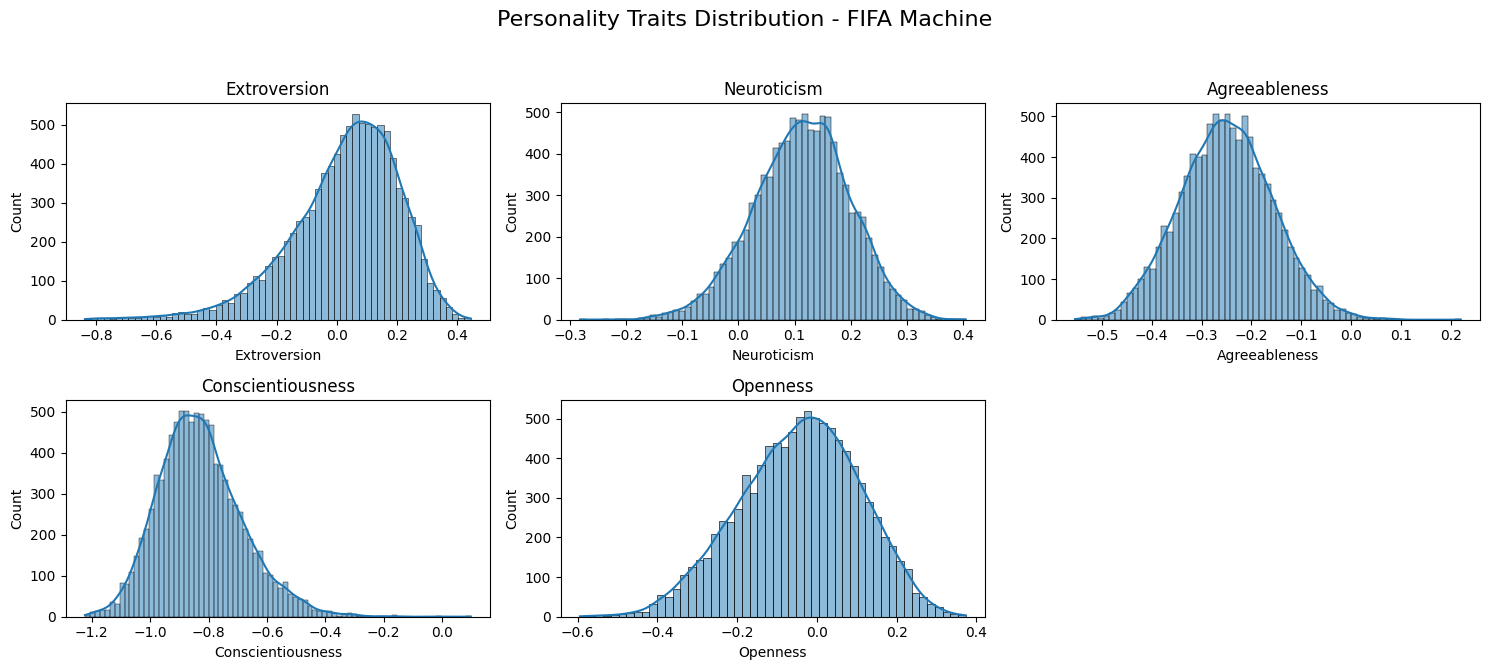

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot histograms
def plot_histograms(df, title):
    plt.figure(figsize=(15, 7))
    plt.suptitle(title, fontsize=16)
    traits = ['Extroversion', 'Neuroticism', 'Agreeableness', 'Conscientiousness', 'Openness']
    for i, trait in enumerate(traits, 1):
        plt.subplot(2, 3, i)
        sns.histplot(df[trait], kde=True)
        plt.title(trait)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_histograms(fifau_traits, 'Personality Traits Distribution - FIFA Users')
plot_histograms(fifam_traits, 'Personality Traits Distribution - FIFA Machine')


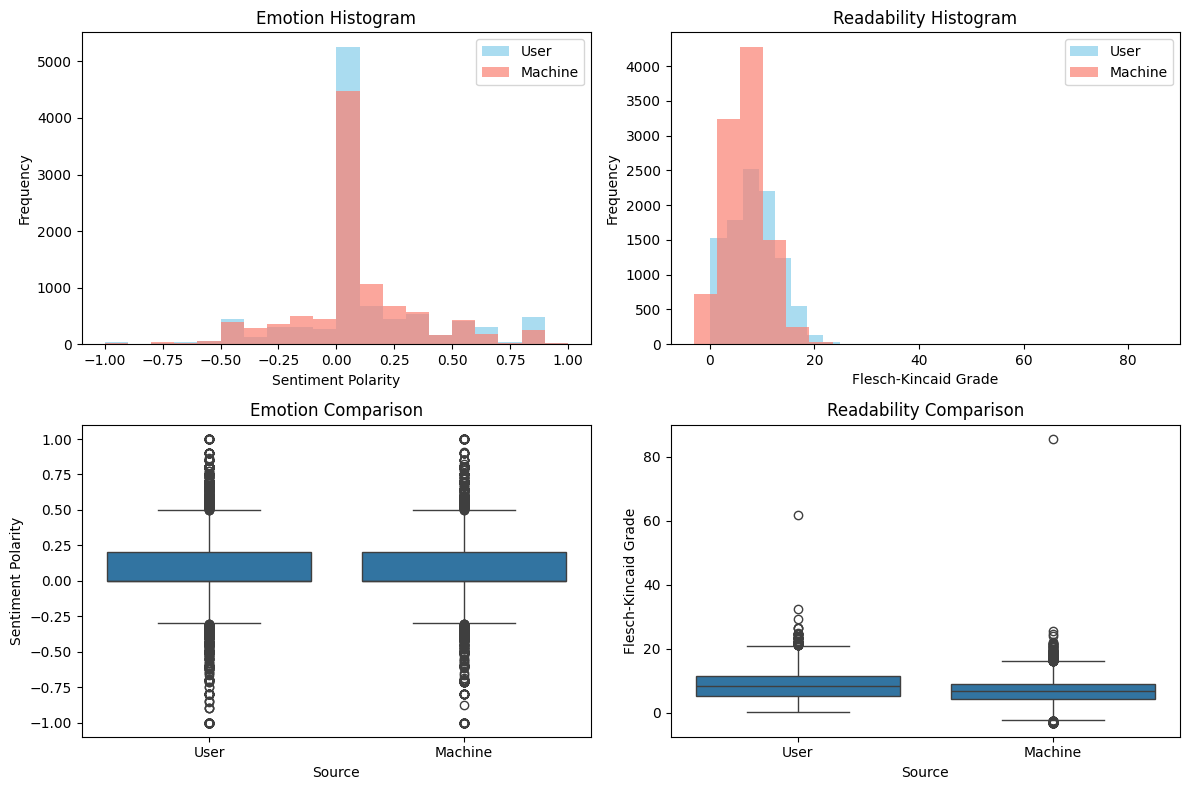

In [10]:
from textblob import TextBlob
import textstat
import matplotlib.pyplot as plt
import seaborn as sns

# Emotion comparison
fifau['sentiment_score'] = fifau['clean_tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)
fifam['sentiment_score'] = fifam['clean_tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Readability comparison
fifau['Readability'] = fifau['clean_tweet'].apply(lambda x: textstat.flesch_kincaid_grade(x))
fifam['Readability'] = fifam['clean_tweet'].apply(lambda x: textstat.flesch_kincaid_grade(x))

# Create subplots for emotion and readability histograms
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Emotion histograms
axs[0, 0].hist(fifau['sentiment_score'], bins=20, color='skyblue', alpha=0.7, label='User')
axs[0, 0].hist(fifam['sentiment_score'], bins=20, color='salmon', alpha=0.7, label='Machine')
axs[0, 0].set_title('Emotion Histogram')
axs[0, 0].set_xlabel('Sentiment Polarity')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].legend()

# Readability histograms
axs[0, 1].hist(fifau['Readability'], bins=20, color='skyblue', alpha=0.7, label='User')
axs[0, 1].hist(fifam['Readability'], bins=20, color='salmon', alpha=0.7, label='Machine')
axs[0, 1].set_title('Readability Histogram')
axs[0, 1].set_xlabel('Flesch-Kincaid Grade')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].legend()

# Emotion boxplots
sns.boxplot(x='source', y='sentiment_score', data=pd.concat([fifau.assign(source='User'), fifam.assign(source='Machine')]), ax=axs[1, 0])
axs[1, 0].set_title('Emotion Comparison')
axs[1, 0].set_xlabel('Source')
axs[1, 0].set_ylabel('Sentiment Polarity')

# Readability boxplots
sns.boxplot(x='source', y='Readability', data=pd.concat([fifau.assign(source='User'), fifam.assign(source='Machine')]), ax=axs[1, 1])
axs[1, 1].set_title('Readability Comparison')
axs[1, 1].set_xlabel('Source')
axs[1, 1].set_ylabel('Flesch-Kincaid Grade')

plt.tight_layout()
plt.show()


In [11]:
gofu=gofu[:10000]
gofm=gofm[:10000]

In [12]:
# Check for non-string entries
print(gofu['clean_tweet'].apply(lambda x: type(x)).value_counts())
print(gofm['clean_tweet'].apply(lambda x: type(x)).value_counts())

# Replace non-string and NaN values with a default string
gofu['clean_tweet'] = gofu['clean_tweet'].fillna('').apply(str)
gofm['clean_tweet'] = gofm['clean_tweet'].fillna('').apply(str)


clean_tweet
<class 'str'>    10000
Name: count, dtype: int64
clean_tweet
<class 'str'>    10000
Name: count, dtype: int64


<ipython-input-12-ad3a0be18a38>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gofm['clean_tweet'] = gofm['clean_tweet'].fillna('').apply(str)


In [13]:
gofu['personality'] = gofu['clean_tweet'].apply(personality_detection)
gofm['personality'] = gofm['clean_tweet'].apply(personality_detection)


In [14]:
import pandas as pd

# Convert dictionary columns into separate columns for each trait
gofu_traits = gofu['personality'].apply(pd.Series)
gofm_traits = gofm['personality'].apply(pd.Series)

# Join these new columns back to the original dataframes if additional data analysis is required
gofu = gofu.join(gofu_traits)
gofm= gofm.join(gofm_traits)


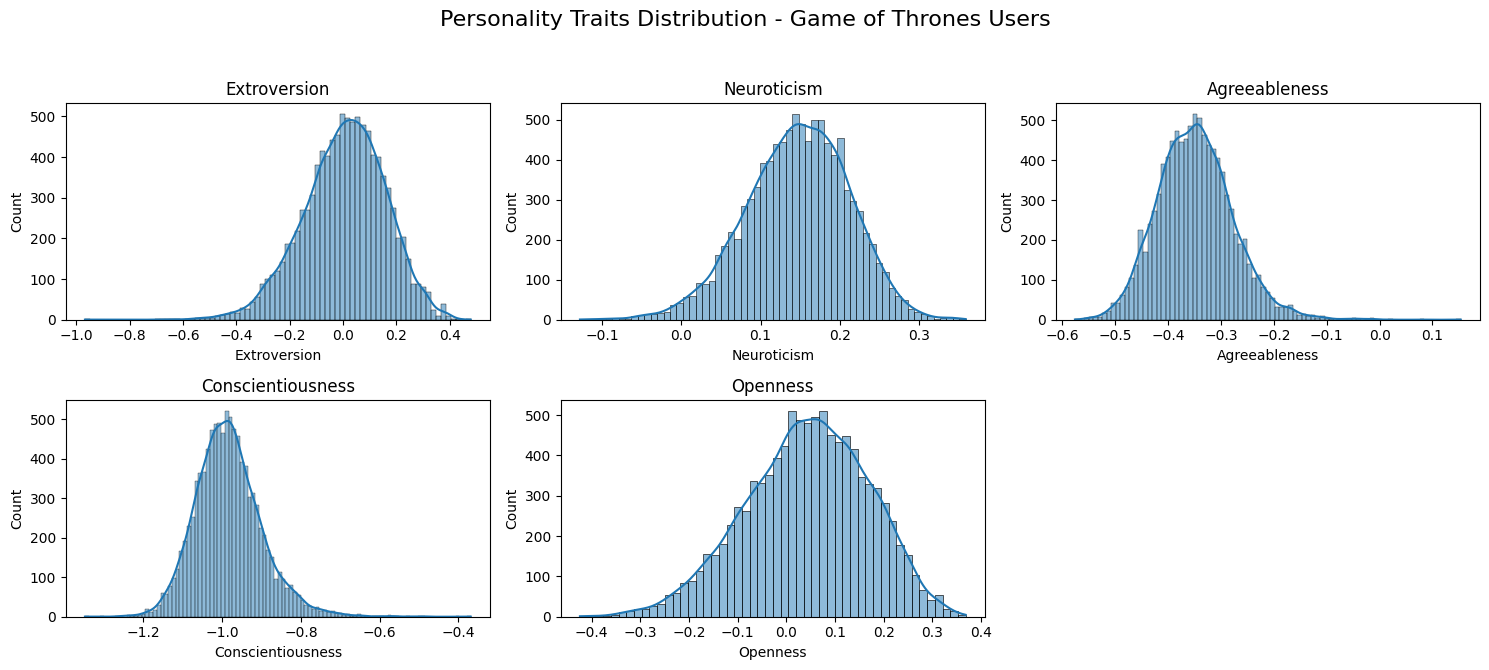

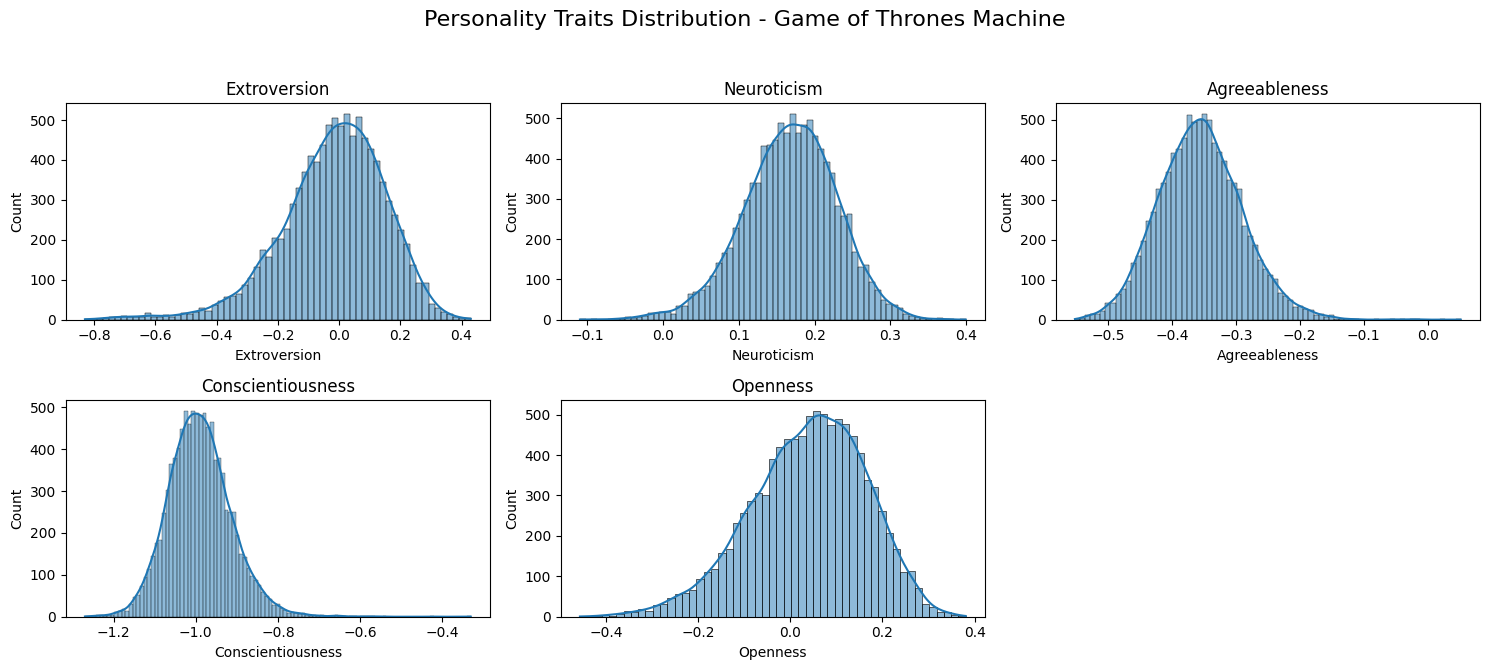

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot histograms
def plot_histograms(df, title):
    plt.figure(figsize=(15, 7))
    plt.suptitle(title, fontsize=16)
    traits = ['Extroversion', 'Neuroticism', 'Agreeableness', 'Conscientiousness', 'Openness']
    for i, trait in enumerate(traits, 1):
        plt.subplot(2, 3, i)
        sns.histplot(df[trait], kde=True)
        plt.title(trait)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_histograms(gofu_traits, 'Personality Traits Distribution - Game of Thrones Users')
plot_histograms(gofm_traits, 'Personality Traits Distribution - Game of Thrones Machine')

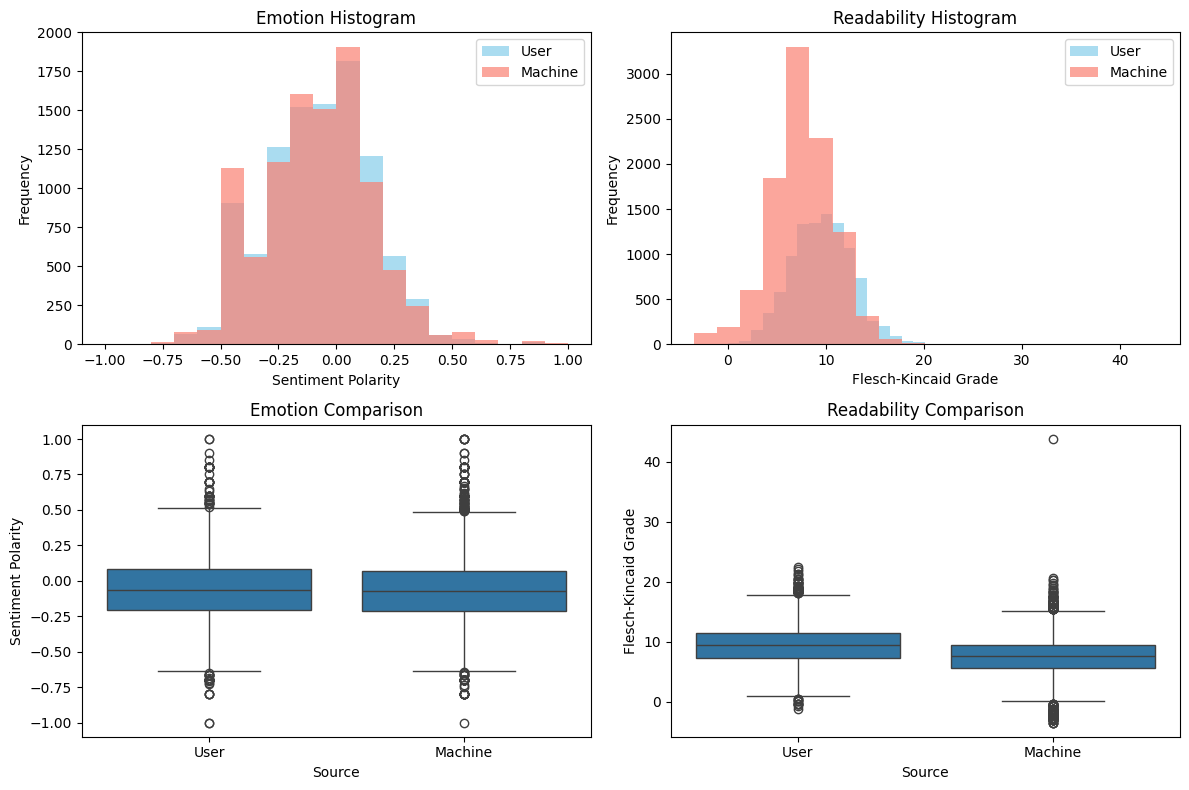

In [16]:
import numpy as np

# Filter out or replace missing values
gofu = gofu.dropna(subset=['clean_tweet']).reset_index(drop=True)
gofm = gofm.dropna(subset=['clean_tweet']).reset_index(drop=True)

# Emotion comparison
gofu['sentiment_score'] = gofu['clean_tweet'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
gofm['sentiment_score'] = gofm['clean_tweet'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Readability comparison
gofu['Readability'] = gofu['clean_tweet'].apply(lambda x: textstat.flesch_kincaid_grade(str(x)))
gofm['Readability'] = gofm['clean_tweet'].apply(lambda x: textstat.flesch_kincaid_grade(str(x)))

# Create subplots for emotion and readability histograms
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Emotion histograms
axs[0, 0].hist(gofu['sentiment_score'], bins=20, color='skyblue', alpha=0.7, label='User')
axs[0, 0].hist(gofm['sentiment_score'], bins=20, color='salmon', alpha=0.7, label='Machine')
axs[0, 0].set_title('Emotion Histogram')
axs[0, 0].set_xlabel('Sentiment Polarity')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].legend()

# Readability histograms
axs[0, 1].hist(gofu['Readability'], bins=20, color='skyblue', alpha=0.7, label='User')
axs[0, 1].hist(gofm['Readability'], bins=20, color='salmon', alpha=0.7, label='Machine')
axs[0, 1].set_title('Readability Histogram')
axs[0, 1].set_xlabel('Flesch-Kincaid Grade')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].legend()

# Emotion boxplots
sns.boxplot(x='source', y='sentiment_score', data=pd.concat([gofu.assign(source='User'), gofm.assign(source='Machine')]), ax=axs[1, 0])
axs[1, 0].set_title('Emotion Comparison')
axs[1, 0].set_xlabel('Source')
axs[1, 0].set_ylabel('Sentiment Polarity')

# Readability boxplots
sns.boxplot(x='source', y='Readability', data=pd.concat([gofu.assign(source='User'), gofm.assign(source='Machine')]), ax=axs[1, 1])
axs[1, 1].set_title('Readability Comparison')
axs[1, 1].set_xlabel('Source')
axs[1, 1].set_ylabel('Flesch-Kincaid Grade')

plt.tight_layout()
plt.show()


In [17]:
elu=elu[:10000]
elm=elm[:10000]

In [18]:
# Check for non-string entries in the elu and elm DataFrames
print(elu['clean_tweet'].apply(lambda x: type(x)).value_counts())
print(elm['clean_tweet'].apply(lambda x: type(x)).value_counts())
# Replace non-string and NaN values with a default string in the elu and elm DataFrames
elu['clean_tweet'] = elu['clean_tweet'].fillna('').apply(str)
elm['clean_tweet'] = elm['clean_tweet'].fillna('').apply(str)


clean_tweet
<class 'str'>    10000
Name: count, dtype: int64
clean_tweet
<class 'str'>    10000
Name: count, dtype: int64


In [19]:
elu['personality'] = elu['clean_tweet'].apply(personality_detection)
elm['personality'] = elm['clean_tweet'].apply(personality_detection)

In [20]:
import pandas as pd

# Convert dictionary columns into separate columns for each trait
elu_traits = elu['personality'].apply(pd.Series)
elm_traits = elm['personality'].apply(pd.Series)

# Join these new columns back to the original dataframes
elu = elu.join(elu_traits)
elm= elm.join(elm_traits)

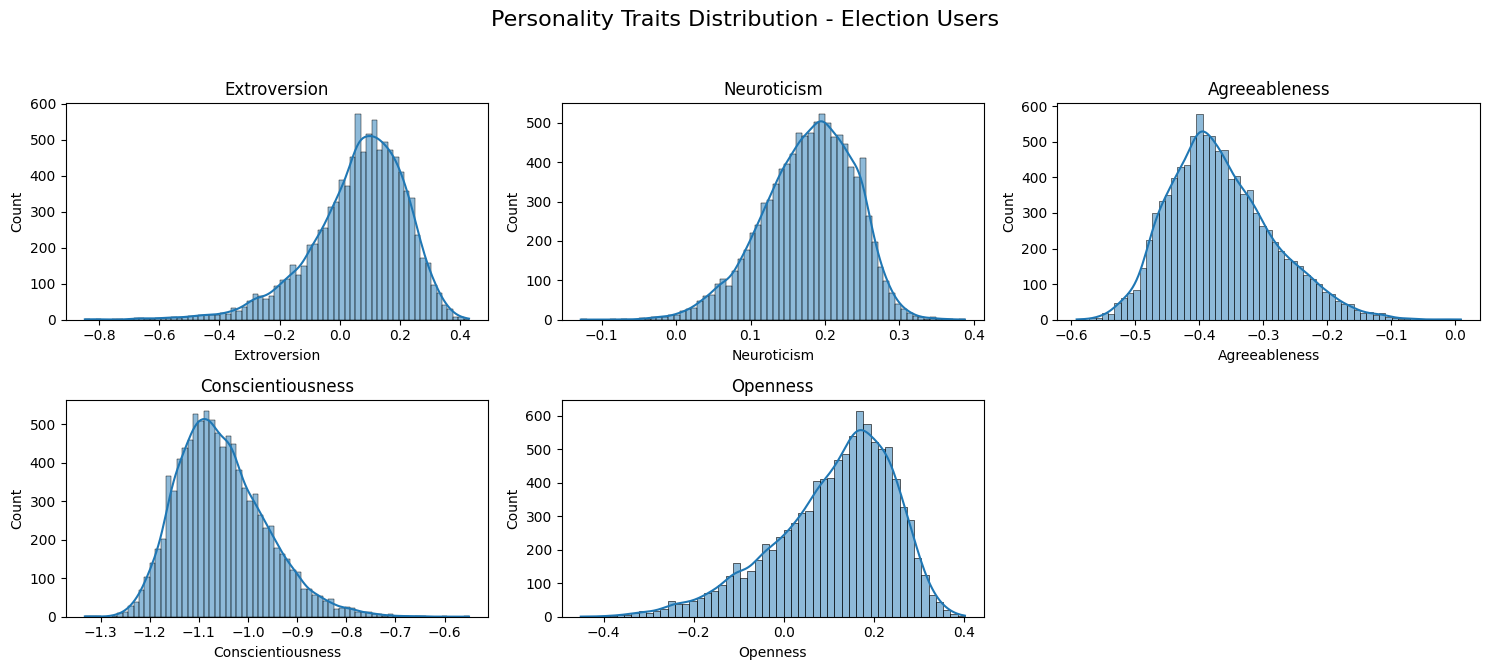

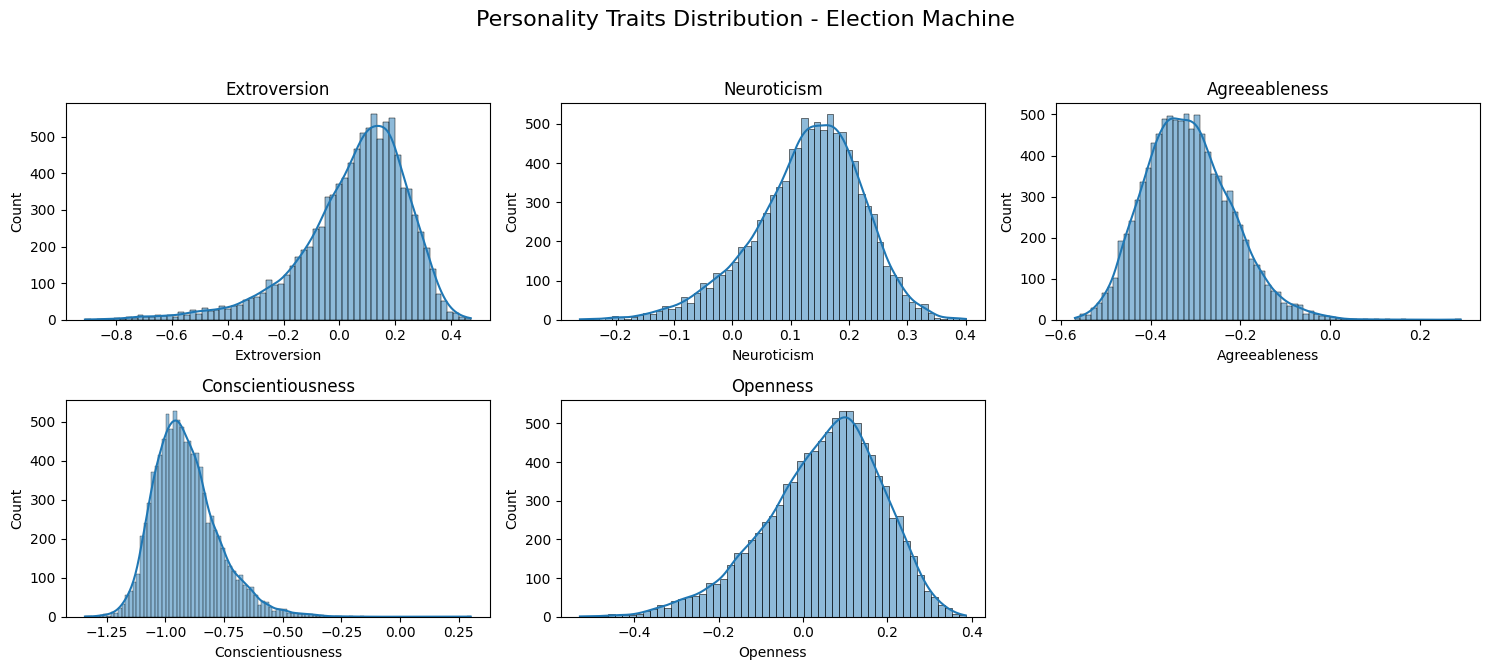

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot histograms
def plot_histograms(df, title):
    plt.figure(figsize=(15, 7))
    plt.suptitle(title, fontsize=16)
    traits = ['Extroversion', 'Neuroticism', 'Agreeableness', 'Conscientiousness', 'Openness']
    for i, trait in enumerate(traits, 1):
        plt.subplot(2, 3, i)
        sns.histplot(df[trait], kde=True)
        plt.title(trait)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_histograms(elu_traits, 'Personality Traits Distribution - Election Users')
plot_histograms(elm_traits, 'Personality Traits Distribution - Election Machine')

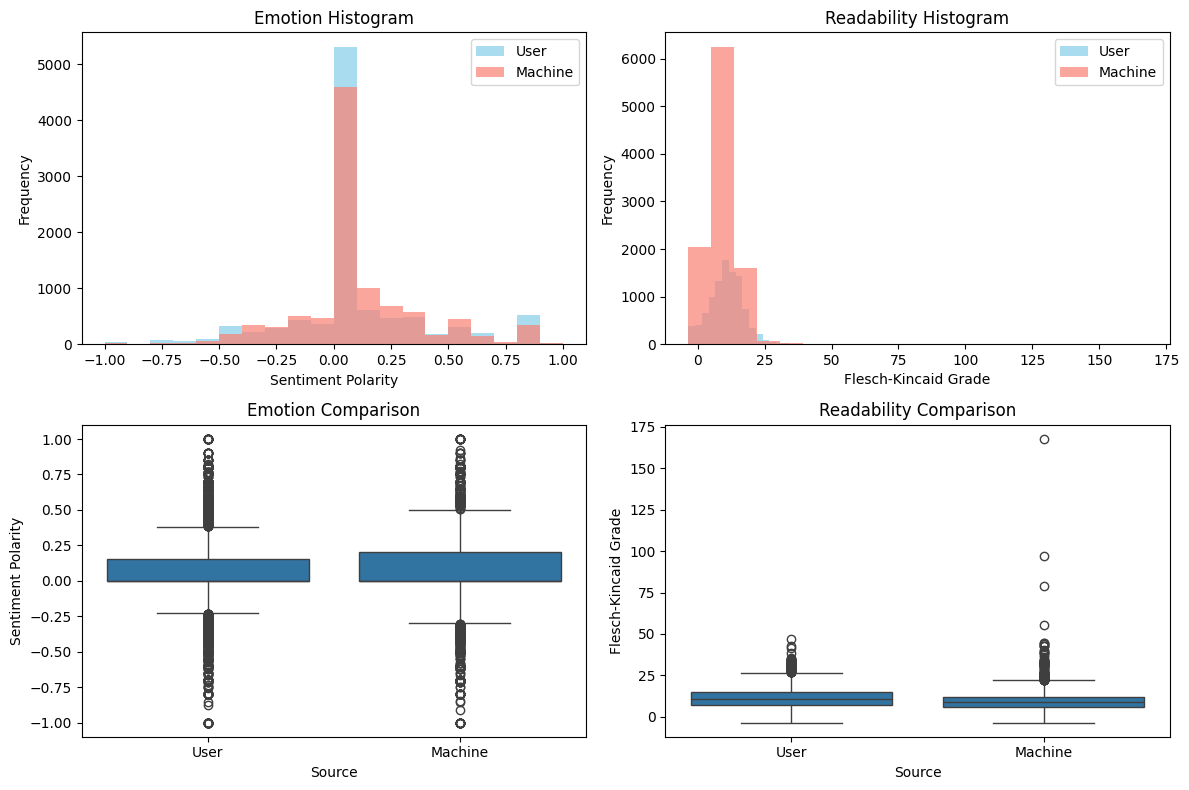

In [22]:
from textblob import TextBlob
import textstat
import matplotlib.pyplot as plt
import seaborn as sns

elu = elu.dropna(subset=['clean_tweet']).reset_index(drop=True)
elm = elm.dropna(subset=['clean_tweet']).reset_index(drop=True)

# Emotion comparison
elu['sentiment_score'] = elu['clean_tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)
elm['sentiment_score'] = elm['clean_tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Readability comparison
elu['Readability'] = elu['clean_tweet'].apply(lambda x: textstat.flesch_kincaid_grade(x))
elm['Readability'] = elm['clean_tweet'].apply(lambda x: textstat.flesch_kincaid_grade(x))

# Create subplots for emotion and readability histograms
fig, axs = plt.subplots(2, 2, figsize=(12, 8))


# Emotion histograms
axs[0, 0].hist(elu['sentiment_score'], bins=20, color='skyblue', alpha=0.7, label='User')
axs[0, 0].hist(elm['sentiment_score'], bins=20, color='salmon', alpha=0.7, label='Machine')
axs[0, 0].set_title('Emotion Histogram')
axs[0, 0].set_xlabel('Sentiment Polarity')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].legend()

# Readability histograms
axs[0, 1].hist(elu['Readability'], bins=20, color='skyblue', alpha=0.7, label='User')
axs[0, 1].hist(elm['Readability'], bins=20, color='salmon', alpha=0.7, label='Machine')
axs[0, 1].set_title('Readability Histogram')
axs[0, 1].set_xlabel('Flesch-Kincaid Grade')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].legend()

# Emotion boxplots
sns.boxplot(x='source', y='sentiment_score', data=pd.concat([elu.assign(source='User'), elm.assign(source='Machine')]), ax=axs[1, 0])
axs[1, 0].set_title('Emotion Comparison')
axs[1, 0].set_xlabel('Source')
axs[1, 0].set_ylabel('Sentiment Polarity')

# Readability boxplots
sns.boxplot(x='source', y='Readability', data=pd.concat([elu.assign(source='User'), elm.assign(source='Machine')]), ax=axs[1, 1])
axs[1, 1].set_title('Readability Comparison')
axs[1, 1].set_xlabel('Source')
axs[1, 1].set_ylabel('Flesch-Kincaid Grade')

plt.tight_layout()
plt.show()
